<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#In-This-Notebook" data-toc-modified-id="In-This-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>In This Notebook</a></span></li><li><span><a href="#Previous-nb's-code-(single-labeled-bbox)" data-toc-modified-id="Previous-nb's-code-(single-labeled-bbox)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Previous nb's code (single labeled bbox)</a></span></li><li><span><a href="#Persons" data-toc-modified-id="Persons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Persons</a></span><ul class="toc-item"><li><span><a href="#Data-pickle" data-toc-modified-id="Data-pickle-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data pickle</a></span></li><li><span><a href="#person-bboxer-(3-bboxes-max)" data-toc-modified-id="person-bboxer-(3-bboxes-max)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>person</code> bboxer (3 bboxes max)</a></span></li></ul></li><li><span><a href="#Pets" data-toc-modified-id="Pets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pets</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Pets-detector-(9-bboxes-max)" data-toc-modified-id="Pets-detector-(9-bboxes-max)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Pets detector (9 bboxes max)</a></span></li></ul></li></ul></div>

# In This Notebook

**Context**

This notebook will take the single labeled bbox code and attempt multiple bounding boxes. I'll start with doing it just for one class (persons), then for persons and barn animals.

**To do:**
* 2020-10-21: use a Transform pad bboxes and lbls with zeros for n_obj < max_obj

**Log**

- 2020-10-20 (Tuesday): Created nb. Created pickle for persons and barn animals.
- 2020-10-21 (Wednesday): Completed persons ETL; ready for dss and dls. Started learning about loss function for SSD. Left off https://www.youtube.com/watch?v=0frKXR-2PBY at 1:24:55.
- 2020-10-22 (Thursday): Person detector (0-3 instances) working.

**Thoughts/Notes:**
- 2020-10-21 (Wed): I should remove images from the dataset that are tricky:
    - 90% background with only tiny people
    - humans in advertisements
    - images with buses (seems to be lots of mistakes)
    - images with partial humans (e.g., hands showing only)
- 2020-10-22 (Thu): I will attempt the problem without using the SSD technique. (Got it working!).
- 2020-10-26 (Mon): Cleaned up code.

# Previous nb's code (single labeled bbox)

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
valid_split  = .15


### Load data (singles) ###
# Grab cols
def grab_cols(df, cols):
    """Expects: DataFrame df; str or list of strs cols. Returns: L or an LoL."""
    def _grab_col(df, col):
        return L((ColReader(col)(df)).to_list())
    
    if isinstance(cols, str): return _grab_col(df, cols)
    if len(cols)==1: return _grab_col(df, cols)
    if len(cols)>=2:
        r=L()
        for c in cols:
            r.append(_grab_col(df,c))
        return r
df = pd.read_pickle(path/'singles.pkl')
imp, lbl, bbox = grab_cols(df, ['im','lbl','bbox'])
bbox = bbox.map(lambda x:list(x)) # fixed pickle bug; lists incorrectly unpickled as tups
# Create getters for pipeline
imp2lbl  = {p:l for p,l in zip(imp,lbl)}
imp2bbox = {p:b for p,b in zip(imp,bbox)}
def get_lbl(p):  return imp2lbl[p]
def get_bbox(p): return imp2bbox[p]

In [ ]:
### Datasets ###
dss_tfms = [[PILImage.create],
            [get_bbox, TensorBBox.create],
            [get_lbl, Categorize()]]
splits = RandomSplitter(valid_split)(imp)
dss = Datasets(imp, tfms=dss_tfms, splits=splits)


### DataLoaders ###
cpu_tfms = [BBoxLabeler(), PointScaler(), Resize(im_size, method='squish'), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
dls = dss.dataloaders(bs=batch_size,after_item=cpu_tfms,after_batch=gpu_tfms,drop_last=True)
dls.n_inp = 1

In [ ]:
### Model ###
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head

    def forward(self, x):
        return self.head(self.body(x))
body = create_body(resnet34, pretrained=True)
head = create_head(1024, 4+dss.c, ps=0.5)
mod  = custom_module(body, head)

In [ ]:
b=dls.one_batch()

In [ ]:
mod.parameters

<bound method Module.parameters of custom_module(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

lr_min: 0.002754228748381138


epoch,train_loss,valid_loss,mse,cel,acc,time
0,4.428718,1.910814,0.327370,0.273964,0.921206,00:13
1,2.472321,0.891280,0.108744,0.347560,0.883268,00:13
2,1.259003,0.817142,0.089122,0.371532,0.892996,00:13
3,0.772788,0.619469,0.066839,0.285272,0.917315,00:13
4,0.577619,0.717790,0.058796,0.423811,0.866732,00:13
5,0.458959,0.731360,0.055761,0.452553,0.883268,00:14
6,0.333283,0.455273,0.042273,0.243909,0.928988,00:14
7,0.229723,0.398860,0.034902,0.224351,0.935798,00:14
8,0.173786,0.330309,0.032314,0.168739,0.956226,00:14
9,0.153074,0.329883,0.031604,0.171862,0.955253,00:14


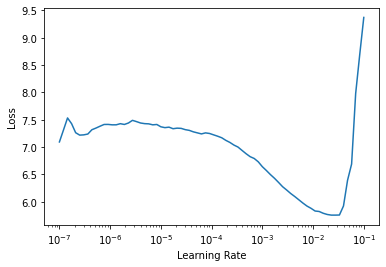

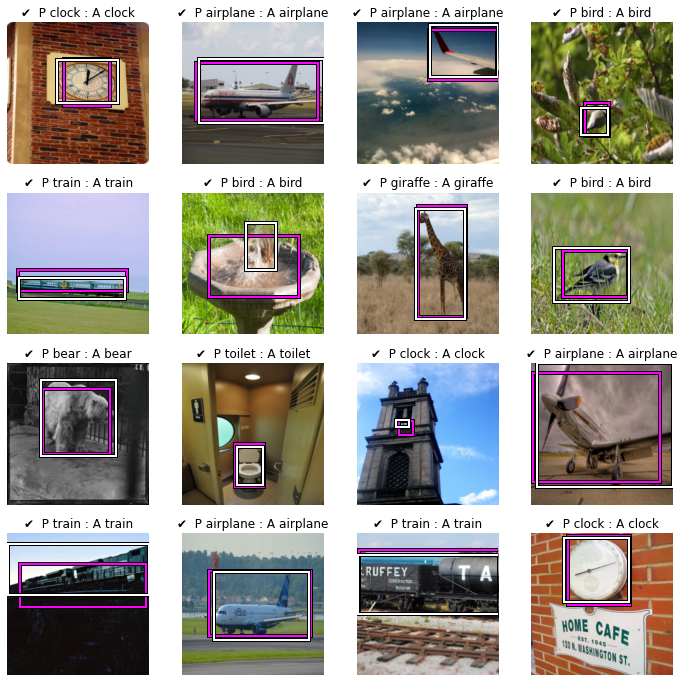

In [ ]:
### Loss ###
def mse(f, bb, lbl): return MSELossFlat()(f[:,:4], torch.squeeze(bb))
def cel(f, bb, lbl): return CrossEntropyLossFlat()(f[:,4:], lbl)
def lbb_loss(f, bb, lbl): return 5*mse(f,bb,lbl) + cel(f,bb,lbl)
def acc(f, bb, lbl): return accuracy(f[:,4:], lbl)


### Training ###
learner = Learner(dls, mod, loss_func=lbb_loss, metrics=[mse, cel, acc])
lr_min, _ = learner.lr_find(); print("lr_min:", lr_min)
learner.fit_one_cycle(10, lr=lr_min)


### Results ###
def view_lbb_results(learner, n=16, nrows=4, ncols=4, offset=0):
    # get batch of ims & targs, get preds
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:4], preds[:,4:].argmax(dim=-1)
    decoded_ims = Pipeline(gpu_tfms).decode(ims)
    
    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        # title
        pred_cls = dls.vocab[pred_lbls[idx].item()]
        targ_cls = dls.vocab[targ_lbls[idx].item()]
        icon = '✔️' if pred_cls==targ_cls else '✖️'
        title = f"{icon}  P {pred_cls} : A {targ_cls}"
        # im
        show_image(decoded_ims[idx], ctx=ctx, title=title)
        # bbs
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx);
view_lbb_results(learner)

# Persons

## Data pickle

In [ ]:
from fastai.vision.all import *

### 40sec ###


### Get files and annos ###
# paths to data
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'
# create lists of items
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]
# create helper cols
is_valid = [0]*len(train_files) + [1]*len(valid_files)
n_items  = L(len(l) for l in lbls)


### Create subsets for task ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos  = L(sort_annos(i) for i in annos)
sorted_bboxes = L(L(o[0] for o in a) for a in sorted_annos)
sorted_lbls   = L(L(o[1] for o in a) for a in sorted_annos)

# persons
person_idxs   = L(L(o=='person' for o in lbl) for lbl in sorted_lbls)
person_lbls   = L(o[i] for o,i in zip(sorted_lbls,  person_idxs))
person_bboxes = L(o[i] for o,i in zip(sorted_bboxes,person_idxs))

# pets
pets_subset  = ['person','cat','dog']
pets_idxs    = L(L(o in pets_subset for o in lbl) for lbl in sorted_lbls)
pets_lbls    = L(o[i] for o,i in zip(sorted_lbls,  pets_idxs))
pets_bboxes  = L(o[i] for o,i in zip(sorted_bboxes,pets_idxs))
n_pets_items = L(len(l) for l in pets_lbls)

# barn
barn_subset  = ['person','cat','dog','cow','sheep','horse']
barn_idxs    = L(L(o in barn_subset for o in lbl) for lbl in sorted_lbls)
barn_lbls    = L(o[i] for o,i in zip(sorted_lbls,  barn_idxs))
barn_bboxes  = L(o[i] for o,i in zip(sorted_bboxes,barn_idxs))
n_barn_items = L(len(l) for l in barn_lbls)

# count instances of each class
def count_instances(lbl, lol): return L(sum([o==lbl for o in l]) for l in lol)
n_persons = count_instances('person', sorted_lbls)
n_cats    = count_instances('cat', sorted_lbls)
n_dogs    = count_instances('dog', sorted_lbls)
n_cows    = count_instances('cow', sorted_lbls)
n_sheep   = count_instances('sheep', sorted_lbls)
n_horses  = count_instances('horses', sorted_lbls)


### Store outputs in a pickle ###
df = pd.DataFrame({
    # basics
    "path": files,
    "lbl":  sorted_lbls,
    "bbox": sorted_bboxes,
    "is_valid": is_valid,
    "n_items": n_items,
    # persons
    "person_lbls": person_lbls,
    "person_bboxes": person_bboxes,
    "n_persons": n_persons,
    # pets
    "pets_lbls": pets_lbls,
    "pets_bboxes": pets_bboxes,
    "n_pets_items": n_pets_items,
    "n_cats": n_cats,
    "n_dogs": n_dogs,
    # barn
    "barn_lbls": barn_lbls,
    "barn_bboxes": barn_bboxes,
    "n_barn_items": n_barn_items,
    "n_cows": n_cows,
    "n_sheep": n_sheep,
    "n_horses": n_horses
    })
df.to_pickle(path/'20201020_coco_multiple_bboxes_df.pkl')

/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1223: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1615: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subarr = np.array(values, dtype=dtype, copy=copy)


## `person` bboxer (3 bboxes max)

In [ ]:
### Unused Helpers ###
# flatten L or list
def flatten(l):
    def _recur(l,res):
        for o in l:
            if isinstance(o,L): _recur(o,res)
            if isinstance(o,list): _recur(o,res)
            else: res.append(o)
        return res
    return _recur(l,L())    

lr_min: 0.002754228748381138


epoch,train_loss,valid_loss,time
0,0.459593,0.219616,00:34
1,0.169573,0.128668,00:34
2,0.128490,0.115672,00:35
3,0.120039,0.121141,00:35
4,0.105094,0.109130,00:35
5,0.090455,0.094929,00:35
6,0.070664,0.090328,00:35
7,0.053525,0.086731,00:35
8,0.041278,0.085162,00:35
9,0.035225,0.085896,00:35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

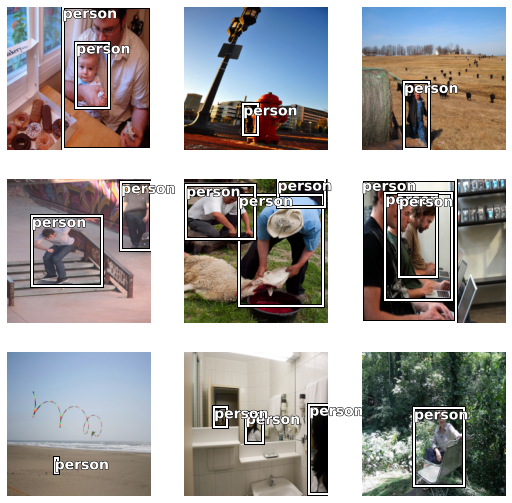

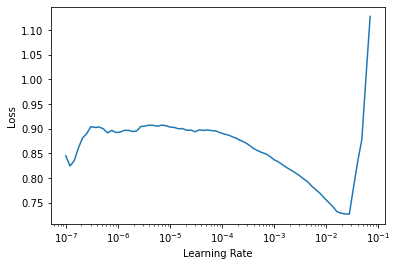

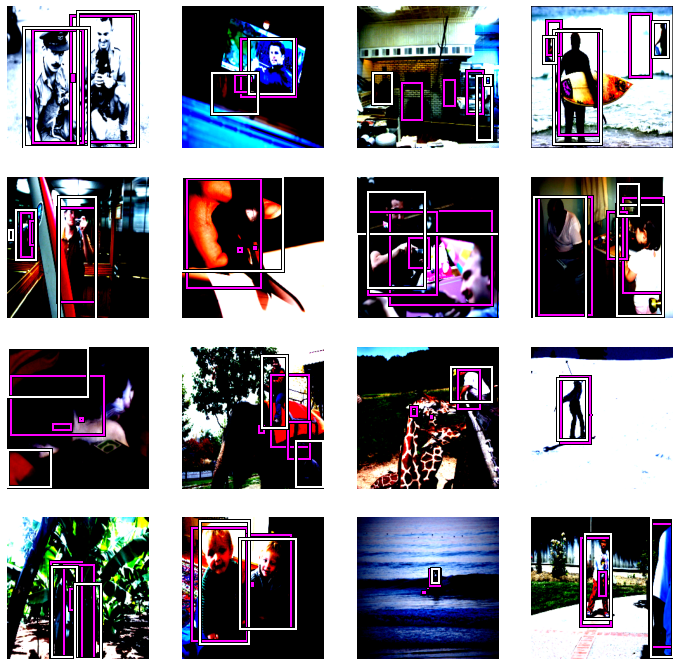

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
path       = Path('/home/rory/data/coco2017')
valid_pct  = .15


### Data ###
df = pd.read_pickle(path/'20201020_coco_multiple_bboxes_df.pkl')
def equalize_row_counts(df, col):
    min_n = min(df[col].value_counts())
    vals = df['n_persons'].unique()
    return pd.concat([df[df[col]==v].sample(n=min_n) for v in vals])
def select_from_where_in(cols, df, where_col, in_vals, eq=False):
    df = df[cols]
    df = pd.concat([df[df[where_col]==v] for v in in_vals])
    if eq: df = equalize_row_counts(df, where_col)
    return df
cols = ['path','person_lbls','person_bboxes','n_persons']
df = select_from_where_in(cols, df, 'n_persons', [1,2,3], eq=True)
def get_cols(df, cols):
    """Expects: DataFrame df; str or list of strs cols. Returns: list or an lol."""
    def c2l(df, col): return L(ColReader(col)(df).to_list())
    if isinstance(cols, str): return c2l(df, cols)
    if len(cols)==1: return c2l(df, cols)
    if len(cols)>=2:
        r=L()
        for c in cols: r.append(c2l(df,c))
        return r
paths,bboxes,lbls = get_cols(df, ['path','person_bboxes','person_lbls'])
path2bbox = {p:b for p,b in zip(paths,bboxes)}
path2lbl  = {p:l for p,l in zip(paths,lbls)}
def get_bbox(p): return path2bbox[p]
def get_lbl(p):  return path2lbl[p]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
dls = db.dataloaders(paths)


### Model ###
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))
body = create_body(resnet34, pretrained=True)
n_cls    = len(dls.vocab)
bb_acts  = 4*3
lbl_acts = n_cls+1
head = create_head(1024, bb_acts+lbl_acts, ps=0.5)
mod  = custom_module(body, head)


### Loss ###
def mse(f, bb, lbl): return MSELossFlat()(f[:,:bb_acts], bb)


### Training ###
learner = Learner(dls, mod, loss_func=mse)
lr_min, _ = learner.lr_find(); print("lr_min:", lr_min)
learner.fit_one_cycle(10, lr=lr_min) # 0.085162
def view_mbb_results(learner, n=16, nrows=4, ncols=4, offset=0):
    # get batch of ims & targs, get preds
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:bb_acts], preds[:,bb_acts:].argmax(dim=-1)
    decoded_ims = ims

    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        # title
    #     pred_cls = dls.vocab[pred_lbls[idx].item()]
    #     targ_cls = dls.vocab[targ_lbls[idx].item()]
    #     icon = '✔️' if pred_cls==targ_cls else '✖️'
    #     title = f"{icon}  P {pred_cls} : A {targ_cls}"
        # im
        show_image(decoded_ims[idx], ctx=ctx)#, title=title)
        # bbs
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx); 
view_mbb_results(learner)

# Pets

## Data

In [ ]:
from fastai.vision.all import *

### 40sec ###


### Get files and annos ###
# paths to data
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'
# create lists of items
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]
# create helper cols
is_valid = [0]*len(train_files) + [1]*len(valid_files)
n_items  = L(len(l) for l in lbls)


### Create subsets for task ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos  = L(sort_annos(i) for i in annos)
sorted_bboxes = L(L(o[0] for o in a) for a in sorted_annos)
sorted_lbls   = L(L(o[1] for o in a) for a in sorted_annos)
# persons
per_idxs   = L(L(o=='person' for o in lbl) for lbl in sorted_lbls)
per_lbls   = L(o[i] for o,i in zip(sorted_lbls,  per_idxs))
per_bboxes = L(o[i] for o,i in zip(sorted_bboxes,per_idxs))
# persons
cat_idxs   = L(L(o=='cat' for o in lbl) for lbl in sorted_lbls)
cat_lbls   = L(o[i] for o,i in zip(sorted_lbls,  cat_idxs))
cat_bboxes = L(o[i] for o,i in zip(sorted_bboxes,cat_idxs))
# persons
dog_idxs   = L(L(o=='dog' for o in lbl) for lbl in sorted_lbls)
dog_lbls   = L(o[i] for o,i in zip(sorted_lbls,  dog_idxs))
dog_bboxes = L(o[i] for o,i in zip(sorted_bboxes,dog_idxs))

# count instances of each class
def count_instances(lbl, lol): return L(sum([o==lbl for o in l]) for l in lol)
n_pers = count_instances('person', sorted_lbls)
n_cats = count_instances('cat',    sorted_lbls)
n_dogs = count_instances('dog',    sorted_lbls)


### Store outputs in a pickle ###
df = pd.DataFrame({
    # basics
    "path": files,
    "per_lbls": per_lbls,
    "cat_lbls": cat_lbls,
    "dog_lbls": dog_lbls,
    "per_bboxes": per_bboxes,
    "cat_bboxes": cat_bboxes,
    "dog_bboxes": dog_bboxes,
    "n_pers": n_pers,
    "n_cats": n_cats,
    "n_dogs": n_dogs,
    })
df.to_pickle(path/'20201020_coco_multiple_bboxes_pets_df.pkl')

/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1223: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1615: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subarr = np.array(values, dtype=dtype, copy=copy)


## Pets detector (9 bboxes max)

In [ ]:
from fastai.vision.all import *
from IPython.display import Markdown, display


### Params ###
im_size     = 224
batch_size  = 64
path        = Path('/home/rory/data/coco2017')
valid_pct   = .15
    

### Data ###
df = pd.read_pickle(path/'20201020_coco_multiple_bboxes_pets_df.pkl')
df['n_pets'] = df.n_pers + df.n_cats + df.n_dogs
df_pets = df.query('n_pers <= 3').query('n_cats <= 3').query('n_dogs <= 3')
df_cats = df_pets.query('n_pets <= 9').query('n_cats in [1,2,3]')
df_dogs = df_pets.query('n_pets <= 9').query('n_dogs in [1,2,3]')
df_pets = pd.concat([df_cats, df_dogs]).reset_index().drop_duplicates('index')
def vc(df,col): return df[col].value_counts()
print(vc(df_pets,'n_pers'),'\n\n',vc(df_pets,'n_cats'),'\n\n',vc(df_pets,'n_dogs'))
def summarize(df):
    def _printmd(string): display(Markdown(string))
    _printmd(f"**Rows:** {df.shape[0]:,}")
    _printmd(f"**Cols:** {df.shape[1]:,} {df.keys().to_list()}")
    display(pd.concat([df.iloc[0:1], df.iloc[-2:-1]]))
summarize(df)

0    5802
1    1574
2     441
3     157
Name: n_pers, dtype: int64 

 0    3752
1    3751
2     433
3      38
Name: n_cats, dtype: int64 

 0    4009
1    3424
2     471
3      70
Name: n_dogs, dtype: int64


**Rows:** 122,218

**Cols:** 11 ['path', 'per_lbls', 'cat_lbls', 'dog_lbls', 'per_bboxes', 'cat_bboxes', 'dog_bboxes', 'n_pers', 'n_cats', 'n_dogs', 'n_pets']

,path,per_lbls,cat_lbls,dog_lbls,per_bboxes,cat_bboxes,dog_bboxes,n_pers,n_cats,n_dogs,n_pets
0,/home/rory/data/coco2017/train2017/000000391895.jpg,"[person, person]",[],[],"[[339.88, 22.16, 493.76, 322.89000000000004], [471.64, 172.82, 507.56, 220.92]]",[],[],2,0,0,2
122216,/home/rory/data/coco2017/val2017/000000394940.jpg,[person],[],[],"[[0.0, 77.18, 425.79, 490.84000000000003]]",[],[],1,0,0,1


In [ ]:
### Items ###
def get_col(df,col): return L(df[col].to_list())
paths      = get_col(df_pets,'path')
per_lbls   = get_col(df_pets,'per_lbls')
cat_lbls   = get_col(df_pets,'cat_lbls')
dog_lbls   = get_col(df_pets,'dog_lbls')
per_bboxes = get_col(df_pets,'per_bboxes')
cat_bboxes = get_col(df_pets,'cat_bboxes')
dog_bboxes = get_col(df_pets,'dog_bboxes')
n_pers     = get_col(df_pets,'n_pers')
n_cats     = get_col(df_pets,'n_cats')
n_dogs     = get_col(df_pets,'n_dogs')

plbls = [l + (3-n)*['x'] for l,n in zip(per_lbls,n_pers)]
clbls = [l + (3-n)*['x'] for l,n in zip(cat_lbls,n_cats)]
dlbls = [l + (3-n)*['x'] for l,n in zip(dog_lbls,n_dogs)]
path2lbl = {pth: p+c+d for pth,p,c,d in zip(paths,plbls,clbls,dlbls)}
def get_lbl(p): return path2lbl[p]

pbbs = [b + (3-n)*[[0,0,0,0]] for b,n in zip(per_bboxes,n_pers)]
cbbs = [b + (3-n)*[[0,0,0,0]] for b,n in zip(cat_bboxes,n_cats)]
dbbs = [b + (3-n)*[[0,0,0,0]] for b,n in zip(dog_bboxes,n_dogs)]
path2bbox = {pth: p+c+d for pth,p,c,d in zip(paths,pbbs,cbbs,dbbs)}
def get_bbox(p): return path2bbox[p]

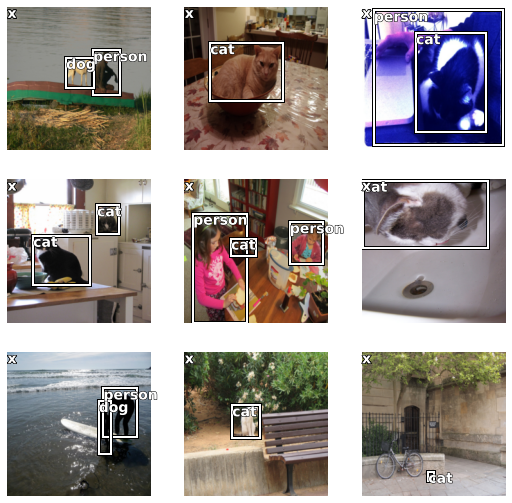

In [ ]:
### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
dls = db.dataloaders(paths)
dls.show_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


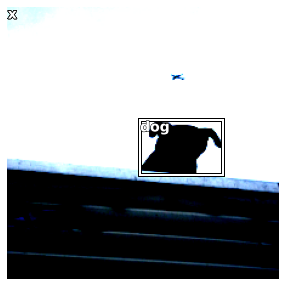

In [ ]:
b = dls.one_batch()
b[0].shape, b[1].shape, b[2].shape

bbs_dec  = TensorBBox((b[1][0]+1)*224//2)
lbls_dec = dls.vocab[list(np.array(b[2][0].cpu()))]
lbbs_dec = LabeledBBox(bbs_dec, lbls_dec)

ctx = show_image(b[0][0]);
lbbs_dec.show(ctx=ctx);

In [ ]:
### Model ###
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))
body = create_body(resnet34, pretrained=True)
max_bbs  = 9
bb_acts  = max_bbs*4
lbl_acts = max_bbs
head = create_head(1024, bb_acts+lbl_acts, ps=0.5)
mod  = custom_module(body, head)


### Loss ###
def mse(f, bb, lbl): return MSELossFlat()(f[:,:bb_acts], bb)

lr_min: 0.002754228748381138


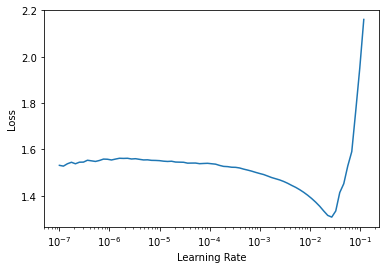

In [ ]:
### Training ###
learner = Learner(dls, mod, loss_func=mse)
lr_min, _ = learner.lr_find(); print("lr_min:", lr_min)

In [ ]:
learner.fit_one_cycle(10, lr=lr_min) # 0.137628

epoch,train_loss,valid_loss,time
0,1.280115,0.855244,00:15
1,0.764047,0.438514,00:16
2,0.378514,0.181193,00:16
3,0.275588,0.211247,00:15
4,0.236953,0.185027,00:15
5,0.220807,0.155529,00:16
6,0.203355,0.144044,00:15
7,0.186612,0.140873,00:16
8,0.178256,0.139132,00:16
9,0.173884,0.137628,00:16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

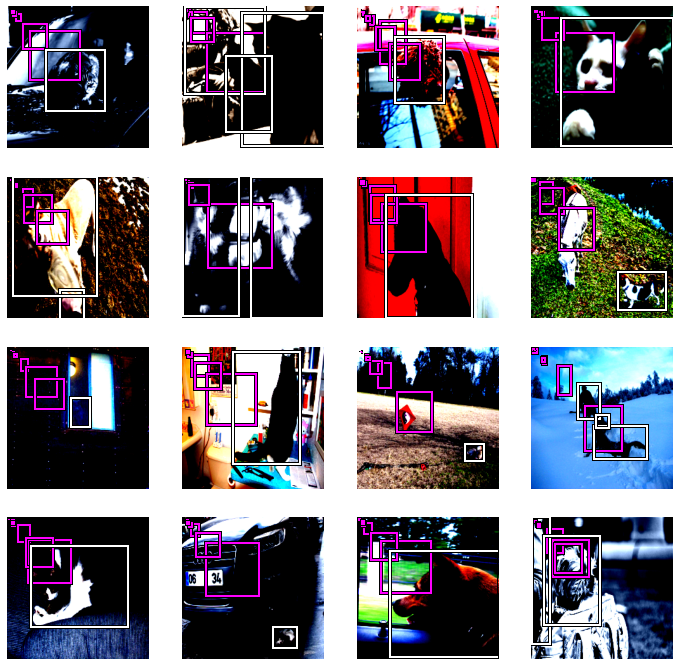

In [ ]:
def view_mbb_results(learner, n=16, nrows=4, ncols=4, offset=0):
    # get batch of ims & targs, get preds
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:bb_acts], preds[:,bb_acts:].argmax(dim=-1)
    decoded_ims = ims

    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        # title
    #     pred_cls = dls.vocab[pred_lbls[idx].item()]
    #     targ_cls = dls.vocab[targ_lbls[idx].item()]
    #     icon = '✔️' if pred_cls==targ_cls else '✖️'
    #     title = f"{icon}  P {pred_cls} : A {targ_cls}"
        # im
        show_image(decoded_ims[idx], ctx=ctx)#, title=title)
        # bbs
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx); 
view_mbb_results(learner)

In [ ]:

def cel(f, bb, lbl): return CrossEntropyLossFlat()(f[:,4:], lbl)
def lbb_loss(f, bb, lbl): return 5*mse(f,bb,lbl) + cel(f,bb,lbl)
def acc(f, bb, lbl): return accuracy(f[:,4:], lbl)